# Tema 1 - Clasificare de Imagini
Mîrza Ana-Maria 341C1

Scopul acestei teme este de a explora modalități de clasificare a imaginilor prin compararea diferitelor modele de antrenare și a extragerilor de atribute. Pentru rezolvarea temei se vor urma următorii pași:
* Vizualizarea și "explorarea" datelor
* Extragerea atribuțiilor din setul de date
* Evaluarea mai multor modele pentru găsirea soluției celei mai bune pentru problema dată

## Setul de date
Vom lucra cu seturile de date [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) și [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits), un set de date RGB cu 70 de tipuri diferite de fructe, legume și nuci. Fashion-MNIST conține imagini cu articole vestimentare în format greyscale. Etichetele din setul de date Fashion-MNIST sunt:

Label - Description 

0  - T-shirt/top

1  - Trouser

2  - Pullover

3  - Dress

4  - Coat

5  - Sandal

6  - Shirt

7  - Sneaker

8  - Bag

9  - Ankle boot



## Fruits-360

### Procesare Set de Date

In [14]:
# Structuri de date și unelte de analiză
import numpy as np
import pandas as pd
import cv2
import glob
import os
import string

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn import metrics
from sklearn.svm import SVC

from skimage.transform import resize
from skimage.feature import hog

# Vizualizare
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dim = 100

In [15]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "./input/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            j=0

            paths = [path + entry.name for entry in os.scandir(path) 
                 if entry.is_dir() and entry.name.startswith(f)]
            for p in paths:
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "./input/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0

                paths = [path + entry.name for entry in os.scandir(path) 
                            if entry.is_dir() and entry.name.startswith(f)]
                for p in paths:
                    for image_path in glob.glob(os.path.join(p, "*.jpg")):
                        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                        image = cv2.resize(image, (dim, dim))
                        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                        images.append(image)
                        labels.append(i)
                        j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("./input/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1].split(" ")[0]
        if fruit not in fruits:
            fruits.append(fruit)
    return fruits

In [16]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos', 'Carrot', 'Guava']
# fruits = getAllFruits()

#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_testt, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_testt])
# X = scaler.fit_transform([i.flatten() for i in X])

There are  983   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  151   TRAINING  images of  CARROT
There are  490   TRAINING  images of  GUAVA
There are  329   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS
There are  50   TEST  images of  CARROT
There are  166   TEST  images of  GUAVA


Pineapple


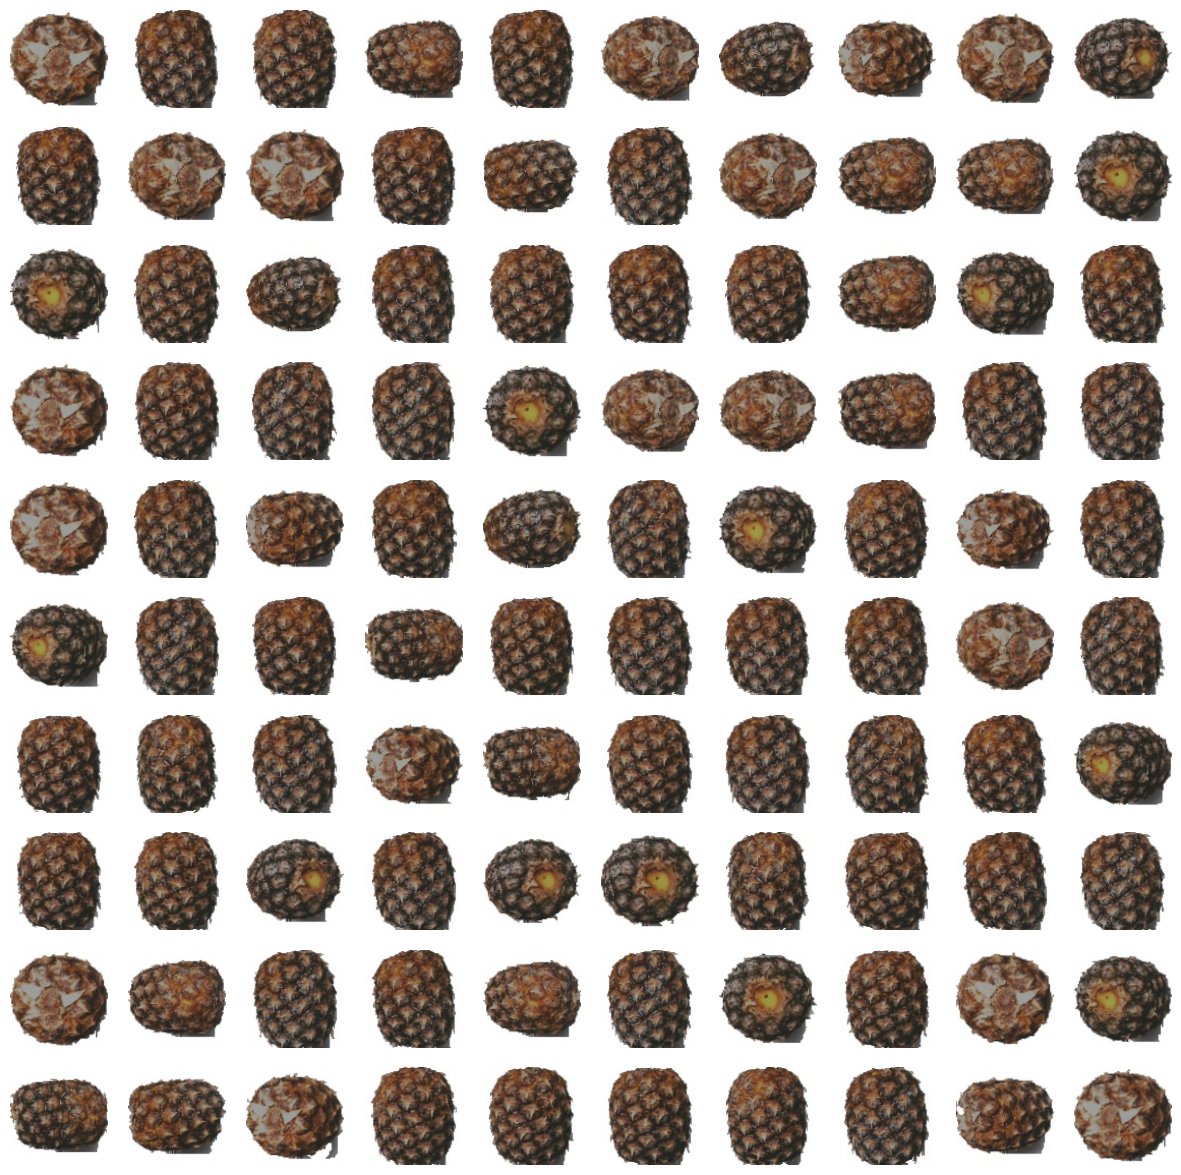

In [17]:
# Vizualizare imagini
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

# Plotare imagini
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

### Echilibrul Setului de Date

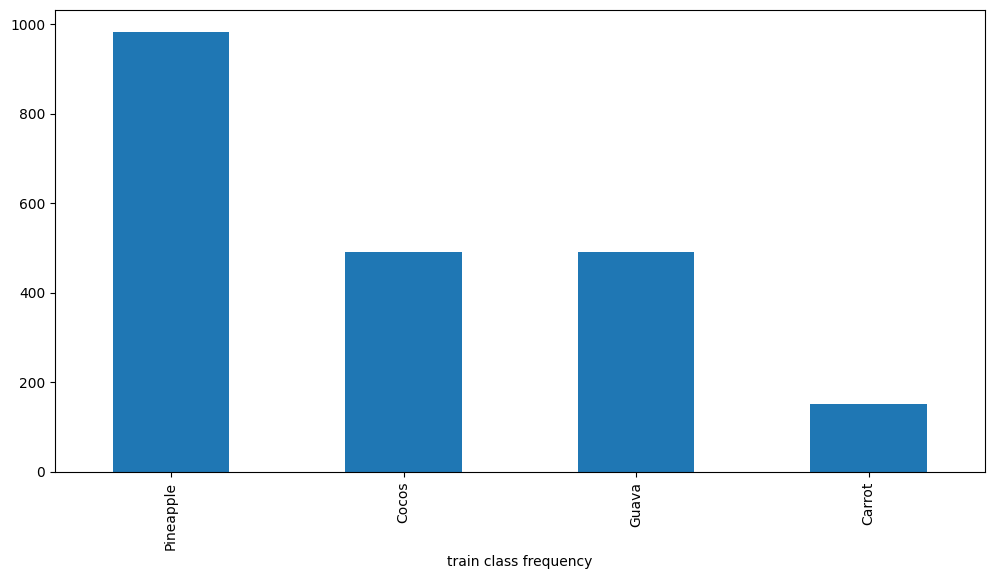

In [18]:
# Analiza echilibrului setului de date de antrenare
y_train2 = [fruits[i] for i in y_train]
df = pd.DataFrame(y_train2, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

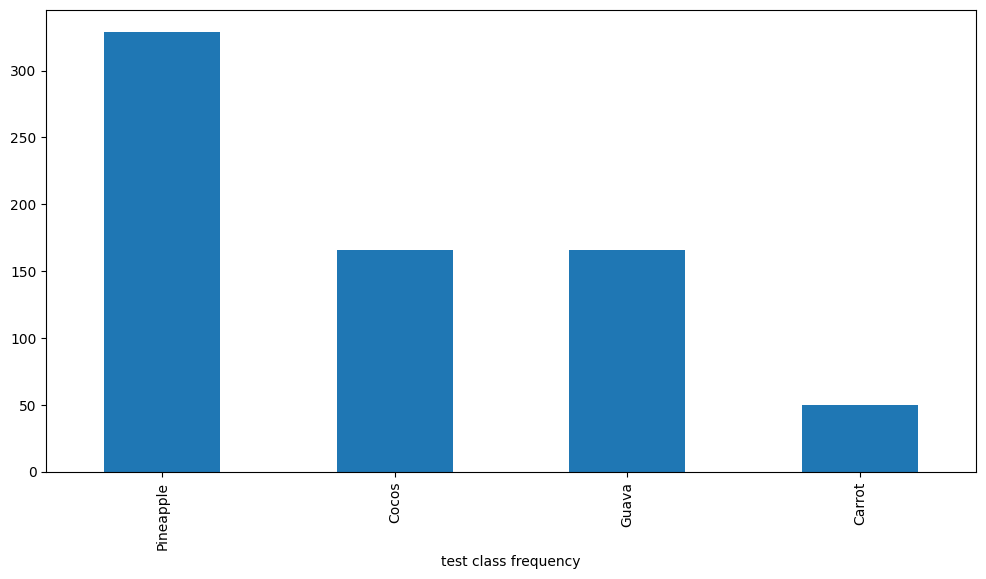

In [6]:
# Analiza echilibrului setului de date de testare
y_test2 = [fruits[i] for i in y_test]
df_test = pd.DataFrame(y_test2, columns=['test class frequency'])
df_test_freq = df_test['test class frequency'].value_counts()

ax = df_test_freq.plot.bar(x='class', y='frequency', rot=90, figsize=(12, 6))

In [19]:
# Cele mai numeroase 10 clase
print(df_freq.sort_values())
top_classes = list(df_freq.sort_values().tail(3).index)
print(f'\nTop classes: {top_classes}')

train class frequency
Carrot       151
Cocos        490
Guava        490
Pineapple    983
Name: count, dtype: int64

Top classes: ['Cocos', 'Guava', 'Pineapple']


### Standardizarea Datelor

In [20]:
# Scalarea datelor de intrare
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = X_train

### Extragerea Atributelor - PCA

In [21]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()
    

Aplicam PCA pe setul de date

In [22]:
# Aplicați PCA pe datele de antrenament și testare
pca = PCA(n_components=20)
X_t20 = pca.fit_transform(X_train)
X_test20 = pca.transform(X_test)

#### Vizualizarea atributiilor extrase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7..309].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [19..322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [32..305].


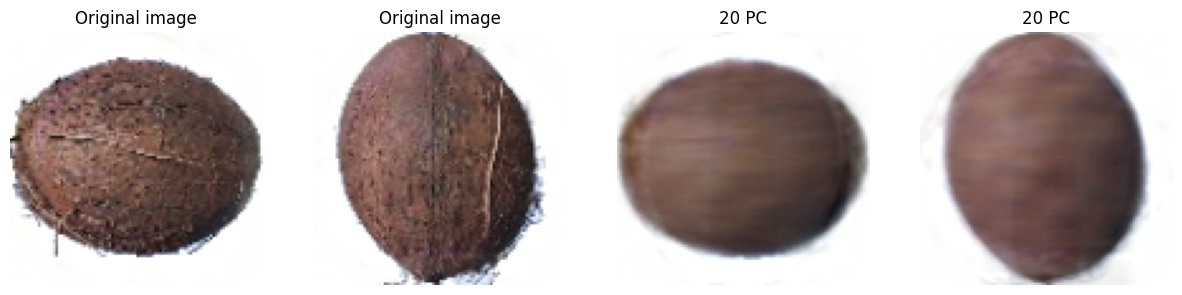

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14..292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18..290].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3..287].


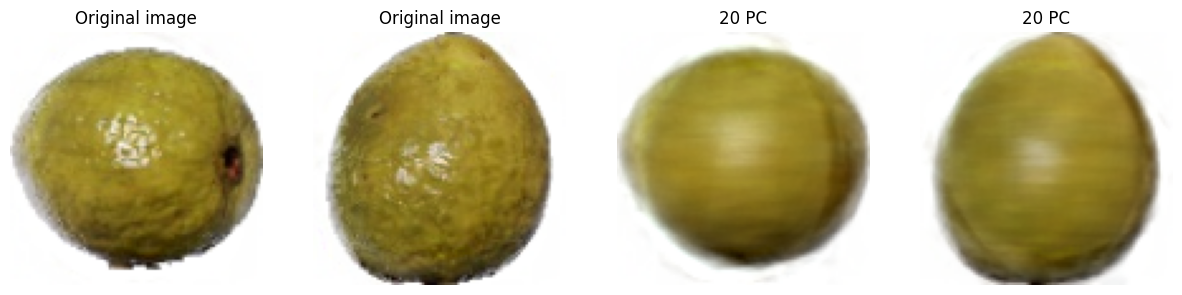

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13..281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4..278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13..307].


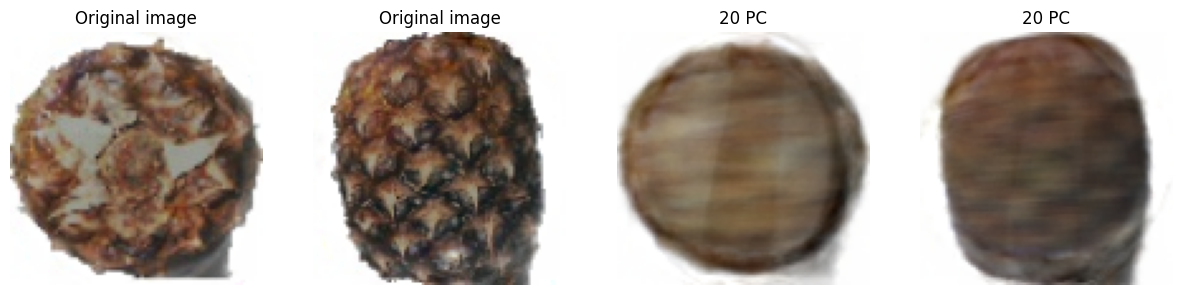

In [23]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image, cmap='Accent')
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('Original image')
    plt.imshow(X2)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('20 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('20 PC')
    plt.imshow(X50)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id].reshape(1, -1))
    return newImage


################################################
for fruit in top_classes:
    index = list(y_train2).index(fruit)

    image1 = scaler.inverse_transform(X_train[index].reshape(1, -1))
    image1 = np.reshape(image1, (dim,dim,3)).astype(int)
    image2 = scaler.inverse_transform(X_train[index + 1].reshape(1, -1))
    image2 = np.reshape(image2, (dim,dim,3)).astype(int)

    image3 = pca.inverse_transform(X_t20[index])
    image3 = scaler.inverse_transform(image3.reshape(1, -1))
    image3 = np.reshape(image3, (dim,dim,3)).astype(int)
    image4 = pca.inverse_transform(X_t20[index + 1])
    image4 = scaler.inverse_transform(image4.reshape(1, -1))
    image4 = np.reshape(image4, (dim,dim,3)).astype(int)

    showPCA(image1, image2, image3, image4)

    # im_reduced = np.array(list(map(lambda x: pca.inverse_transform(x), X_t20)))
    # reshaped = np.array(list(map(lambda x: scaler.inverse_transform(x.reshape(1, -1)), im_reduced)))
    # new_image = np.array(list(map(lambda x: np.reshape(x, (dim,dim,3)).astype(int), reshaped)))
    # reshaped = np.array(list(map(lambda x: scaler.inverse_transform(x.reshape(1, -1)), X_train)))
    # new_image_orig = np.array(list(map(lambda x: np.reshape(x, (dim,dim,3)).astype(int), reshaped)))

    # showPCA(new_image_orig[index], new_image_orig[index + 1], new_image[index], new_image[index + 1])
################################################

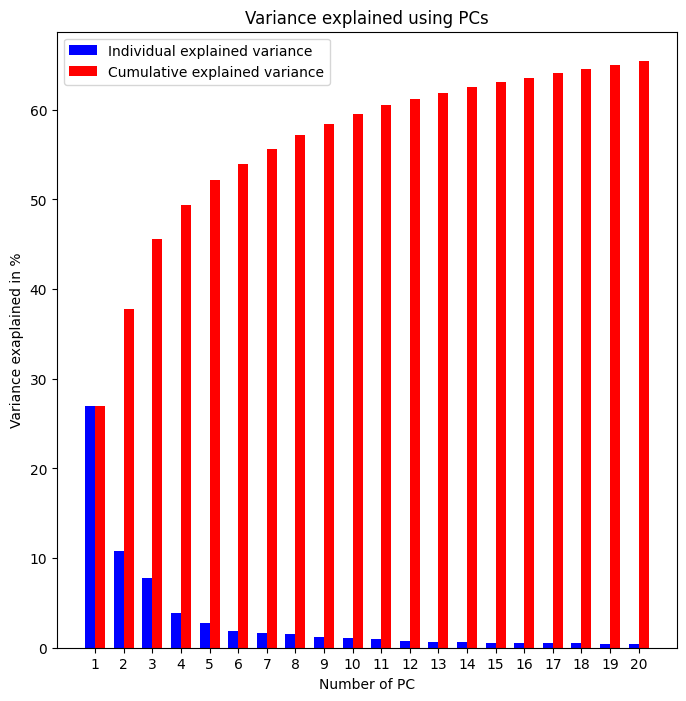

In [24]:
def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(20):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(20)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

# Plotarea viariantei
showVariance(scaled_X_train)

### Selectia Atributelor - HOG 

In [25]:
# Vizualizare atribute extrase
def showHOG(X_train, X_resized, X_hog, index):
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(X_train[index], cmap="gray")
    plt.title("original")
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(X_resized[index], cmap="gray")
    plt.title("resized")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(X_hog[index], cmap="gray")
    plt.title("hog")
    plt.show()

# Redimensionarea unei imagini
def resize_image(img):
    resized_img = resize(img, (128, 64))
    return resized_img

# Aplicare hog
def apply_hog(resized_img):
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

TypeError: Invalid shape (30000,) for image data

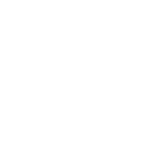

In [26]:
# Procesare si vizualizare a algoritmului hog
X_resized = np.array(list(map(resize_image, X_t)))
tuple_list = list(map(apply_hog, X_resized))

X_trainHOG = np.array([i[0] for i in tuple_list])
X_hog_image = np.array([i[1] for i in tuple_list])

# Aplicare HOG pe setul de testare
X_resized = np.array(list(map(resize_image, X_testt)))
tuple_list = list(map(apply_hog, X_resized))
X_testHOG = np.array([i[0] for i in tuple_list])

# Vizualizare pe cele mai numeroase clase
for fruit in top_classes:
    index = list(y_train2).index(fruit)
    showHOG(X_train, X_resized, X_hog_image, index)

(100, 100, 3)
(128, 64, 3)


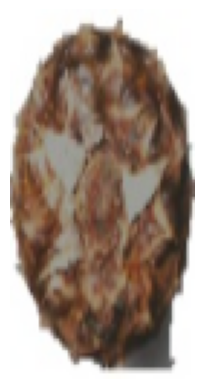

In [ ]:
resized_img = resize(X_t[0], (128, 64))
plt.axis("off")
plt.imshow(resized_img)

print(X_t[0].shape)
print(resized_img.shape)

### Selectia Atributelor

In [281]:
sel = VarianceThreshold(threshold=(0.01))
sel_percentile = SelectPercentile(chi2, percentile=80)
sel_percentile2 = SelectPercentile(percentile=80)

print(f'PCA: X shape before applying variance threashold: {X_t20.shape}')
X_t20_scaled = sel.fit_transform(X_t20)
print(f'PCA: X shape after applying variance threashold: {X_t20_scaled.shape}')
X_t20_scaled = sel_percentile2.fit_transform(X_t20, y_train)
X_test20_scaled = sel_percentile2.fit_transform(X_test20, y_test)
print(f'PCA: X shape after applying percentile selector: {X_t20_scaled.shape}')

print(f'\nHOG: X shape before applying variance threashold: {X_trainHOG.shape}')
X_trainHOG_scaled1 = sel.fit_transform(X_trainHOG)
X_testHOG_scaled1 = sel.transform(X_testHOG)
print(f'HOG: X shape after applying variance selector: {X_trainHOG_scaled1.shape}')
X_trainHOG_scaled = sel_percentile2.fit_transform(X_trainHOG, y_train)
X_testHOG_scaled = sel_percentile2.fit_transform(X_testHOG, y_test)
print(f'HOG: X shape after applying percentile selector: {X_trainHOG_scaled.shape}')

PCA: X shape before applying variance threashold: (2114, 20)
PCA: X shape after applying variance threashold: (2114, 20)
PCA: X shape after applying percentile selector: (2114, 16)

HOG: X shape before applying variance threashold: (2114, 3780)
HOG: X shape after applying variance selector: (2114, 852)
HOG: X shape after applying percentile selector: (2114, 3024)


In [282]:
# Impartirea setului de date
X_train_final_hog, X_validation_hog, y_train_final_hog, y_validation_hog = train_test_split(X_trainHOG_scaled1, y_train) 
X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca = train_test_split(X_t20_scaled, y_train) 


### Antrenarea Modelelor

In [283]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, precision_score, accuracy_score
import multiprocessing
from sklearn.datasets import fetch_california_housing
import xgboost as xgb

#### Antrenare modele folosind atributele PCA

In [ ]:
# Logistic Regression + PCA
clf = LogisticRegression()
clf = clf.fit(X_t20_scaled, y_train)
test_predictions = clf.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}%".format(precision))

# SVM + PCA
svm = SVC()
svm = svm.fit(X_t20_scaled, y_train) 
test_predictions = svm.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering first 20PC: {0:.2f}%".format(precision))

# Random Forest + PCA
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_t20_scaled, y_train)
test_predictions = random_forest.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))

# Gradient Boosted Trees + PCA
xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()
    )
xgb_model.fit(X_t20_scaled, y_train)
test_predictions = xgb_model.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Gradient Boosted Trees considering first 20PC: {0:.2f}%".format(precision))

Accuracy with Logistic Regression considering first 20PC: 94.51%
Accuracy with SVM considering first 20PC: 97.89%
Accuracy with Random Forest considering first 20PC: 96.91%
Accuracy with Gradient Boosted Trees considering first 20PC: 92.97%

Accuracy with Logistic Regression unscaled: 96.77%
Accuracy with SVM considering unscaled: 98.59%
Accuracy with Random Forest unscaled: 97.05%
Accuracy with Gradient Boosted Trees unscaled: 96.62%


##### Logistic Regression

In [285]:
# Hyperparameter Tunning
param_grid = [
    {'penalty':['l1','l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['liblinear'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr']
    },
    {'penalty':['l2'],
    'C' : [0.1, 1, 0.01],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter'  : [500, 1000],
    'multi_class' : ['ovr', 'multinomial']
    },
    {'penalty':['elasticnet'],
    'C' : [0.1, 1, 0.01],
    'solver': ['saga'],
    'max_iter'  : [500, 1000],
    'l1_ratio' : [0, 0.1, 0.5],
    'multi_class' : ['ovr', 'multinomial']
    }
]

grid = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

In [286]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Logistic Regression considering first 20PC: 95.08%
{'C': 1, 'max_iter': 500, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


##### SVM

In [287]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 1, 10],  
              'gamma': ['scale', 'auto'], 
              'kernel': ['poly', 'rbf'],
              'random_state': [0, 16, 19, None] 
            }
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [288]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with SVM considering first 20PC: 95.64%
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 0}


##### Random Forest

In [289]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8, 12, 15, None],
    'max_samples': [0.3, 0.7, 1.0, None]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [290]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Random Forest considering first 20PC: 96.91%
{'max_depth': 8, 'max_samples': 0.7, 'n_estimators': 50}


##### Gradient Boosted Trees

In [291]:
# Hyperparameter Tunning
param_grid = {
    "max_depth": [2, 4, 6], 
    "num_parallel_tree": [1, 3, 5],
    "eta": [0.15, 0.3, 0.45]
}
grid = GridSearchCV(
    xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()),
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
)
grid.fit(X_validation_pca, y_validation_pca)

# Training model 
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

In [292]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Gradient Boosted Treea considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Gradient Boosted Treea considering first 20PC: 94.80%
{'eta': 0.45, 'max_depth': 2, 'num_parallel_tree': 1}


#### Antrenare modele folosind atributele HOG

In [ ]:
# Logistic Regression + HOG
clf = LogisticRegression()
clf = clf.fit(X_trainHOG_scaled1, y_train)
test_predictions = clf.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression and hog: {0:.2f}%".format(precision))

# SVM + HOG
svm = SVC()
svm = svm.fit(X_trainHOG_scaled1, y_train) 
test_predictions = svm.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM and hog: {0:.2f}%".format(precision))

# Random Forest + HOG
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_trainHOG_scaled1, y_train)
test_predictions = random_forest.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest and hog: {0:.2f}%".format(precision))

# Gradient Boosted Trees + HOG
xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count())
xgb_model.fit(X_trainHOG_scaled1, y_train)
test_predictions = xgb_model.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Gradient Boosted Trees and hog: {0:.2f}%".format(precision))

Accuracy with Logistic Regression and hog: 97.89%
Accuracy with SVM and hog: 98.45%
Accuracy with Random Forest and hog: 99.86%
Accuracy with Gradient Boosted Trees considering first 20PC: 98.87%


##### Logistic Regression

In [93]:
# Hyperparameter Tunning
param_grid = [
    {'C' : [0.2, 0.5, 1.0],
    'multi_class' : ['ovr', 'multinomial', 'auto'],
    'max_iter': [200, 300],
    'random_state': [0, 10, 16, None]
    }
]

grid = HalvingGridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

In [94]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Logistic Regression and HOG: 97.89%
{'C': 1.0, 'max_iter': 300, 'multi_class': 'multinomial', 'random_state': 0}


##### SVM

In [91]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 0.5, 1],  
              'gamma': ['scale', 'auto'], 
              'kernel': ['poly', 'rbf']
            }

grid = GridSearchCV(SVC(), param_grid, refit = 'accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

In [92]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with SVM and HOG: 98.17%
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


##### Random Forest

In [98]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 8, 12, 15],
    'max_samples': [0.5, 0.7, 0.9, 1.0]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = 'accuracy', n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

In [99]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forests and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Random Forests and HOG: 98.45%
{'max_depth': 5, 'max_samples': 1.0, 'n_estimators': 150}


##### Gradient Boosted Trees

In [103]:
# Hyperparameter Tunning
param_grid = {
    "max_depth": [2, 4, 6], 
    "num_parallel_tree": [1, 3, 5],
    "eta": [0.15, 0.3, 0.45]
}
grid = HalvingGridSearchCV(
    xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()),
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
)
grid.fit(X_validation_hog, y_validation_hog)

# Training model 
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

/home/anami/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anami/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anami/.local/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/anami/.local/lib/python3.11/site-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferre

In [102]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Gradient Boosted Trees and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Gradient Boosted Trees and HOG: 96.77%
{'eta': 0.15, 'max_depth': 2, 'num_parallel_tree': 1}


---
## Fashion-MNIST

### Procesare Set de Date

In [26]:
import mnist_reader

X_train, y_train = mnist_reader.load_mnist('input/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('input/fashion', kind='t10k')

print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)

(60000, 784)
(784,)
(10000, 784)


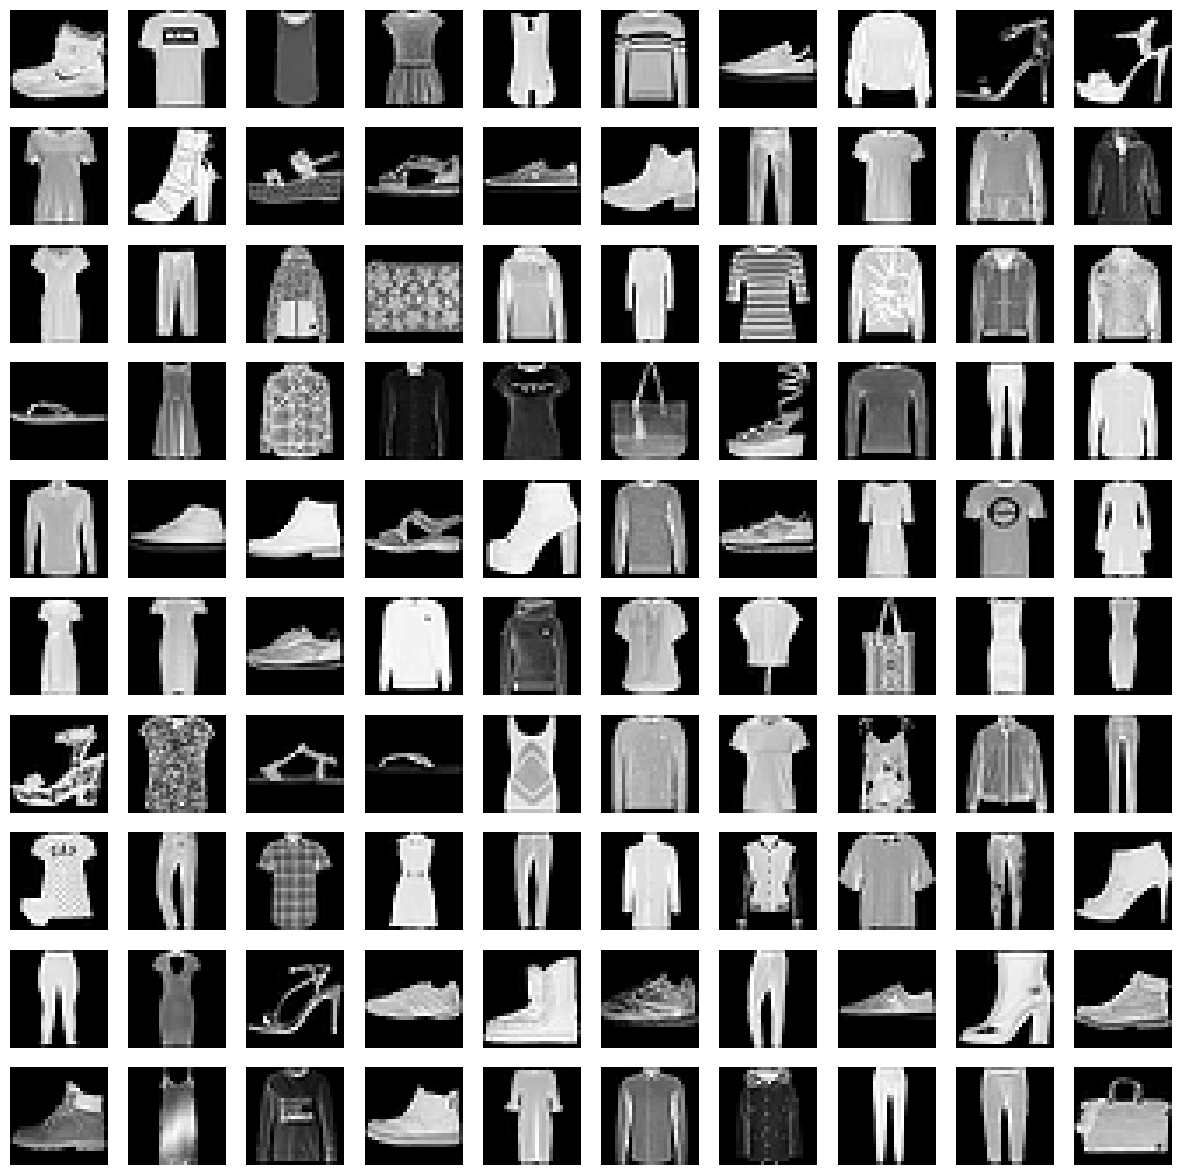

In [4]:
# Vizualizare date
def gen_image(first_image):
    first_image = np.array(first_image)
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    return plt

def plot_mnist_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            first_image = np.array(images[i * nb_rows + j])
            pixels = first_image.reshape((28, 28))

            if nb_rows > 1:
                axs[i, j].axis('off')
                axs[i, j].imshow(pixels, cmap='gray')
            else:
                axs[j].axis('off')
                axs[j].imshow(pixels, cmap='gray')
            n += 1
            
plot_mnist_grid(X_train[:100], 10, 10)

### Echilibrul Setului de Date

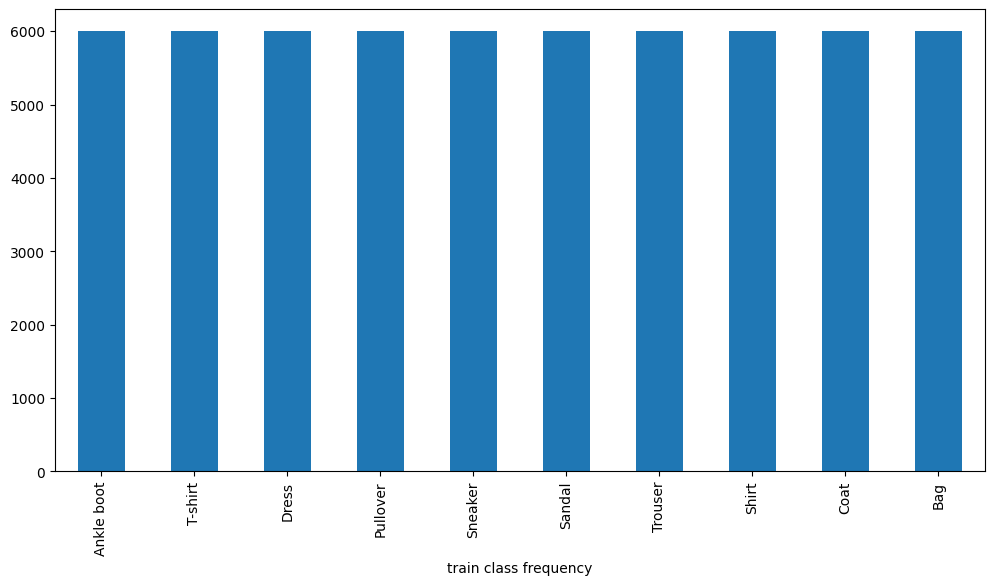

In [27]:
# Vizualizarea echilibrului dater de antrenare
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

mapped_y = [labels[i] for i in y_train]
df = pd.DataFrame(mapped_y, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

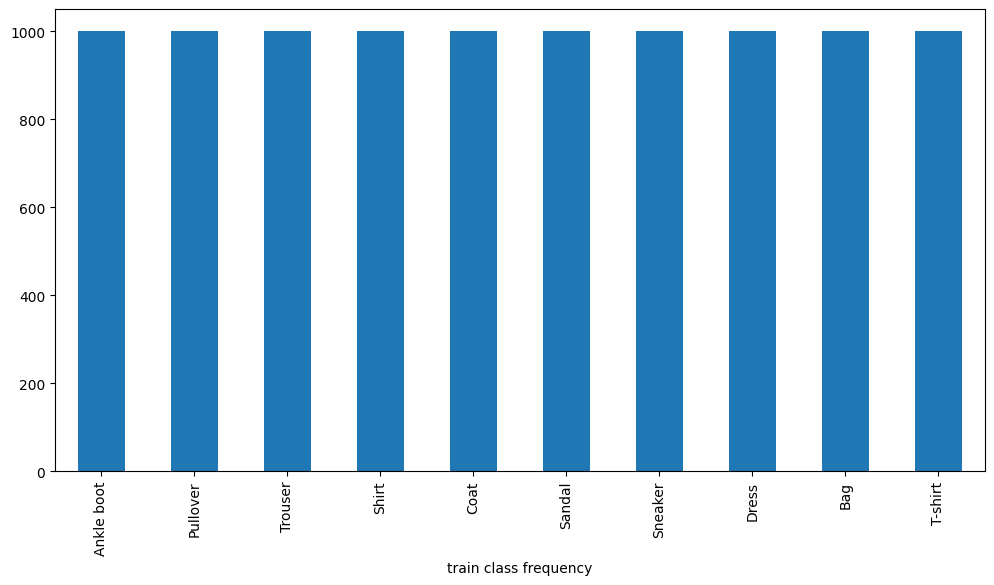

In [28]:
# Vizualizarea echilibrului dater de testare
mapped_y = [labels[i] for i in y_test]
df = pd.DataFrame(mapped_y, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

### Standardizarea Datelor

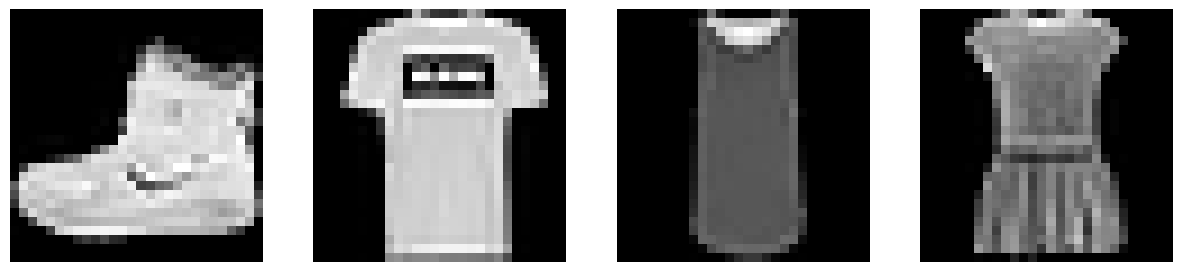

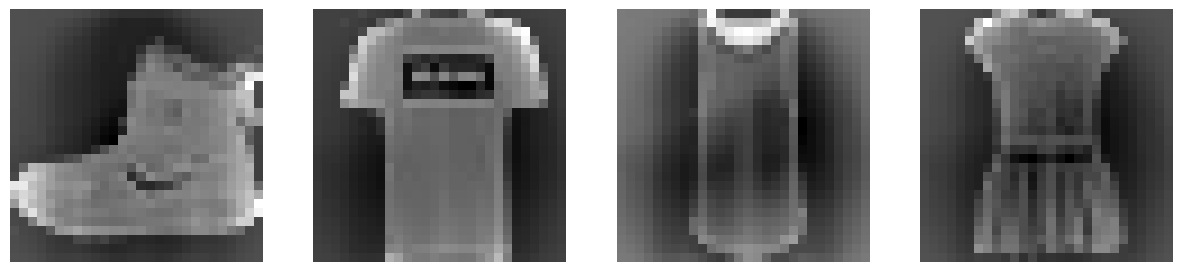

In [29]:
# Scalarea datelor de intrare
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

plot_mnist_grid(X_train[:4], 1, 4)
plot_mnist_grid(scaled_X_train[:4], 1, 4)

### Extragerea Atributelor - 1

In [8]:
# Aplicați PCA pe datele de antrenament și testare
pca = PCA(n_components=20)
X_t20 = pca.fit_transform(scaled_X_train)
X_test20 = pca.transform(X_test)

print(scaled_X_train.shape)
print(X_t20.shape)

(60000, 784)
(60000, 20)


['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


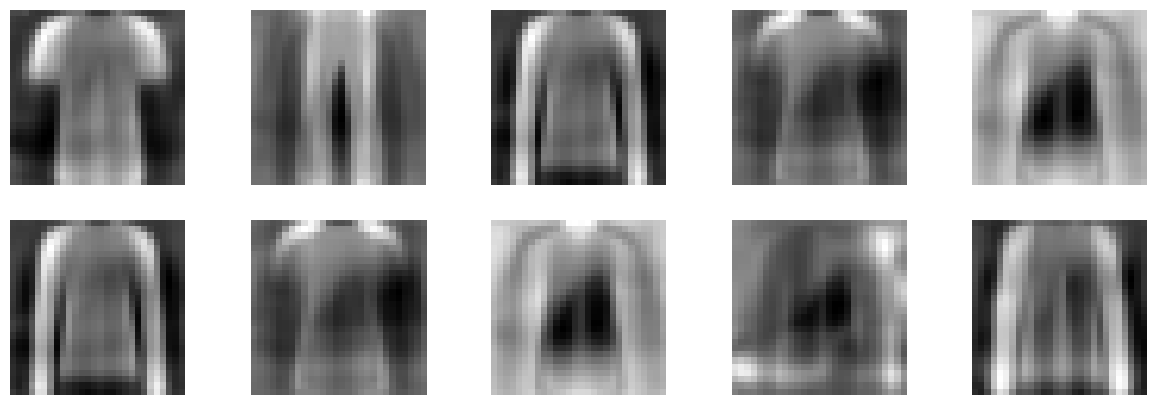

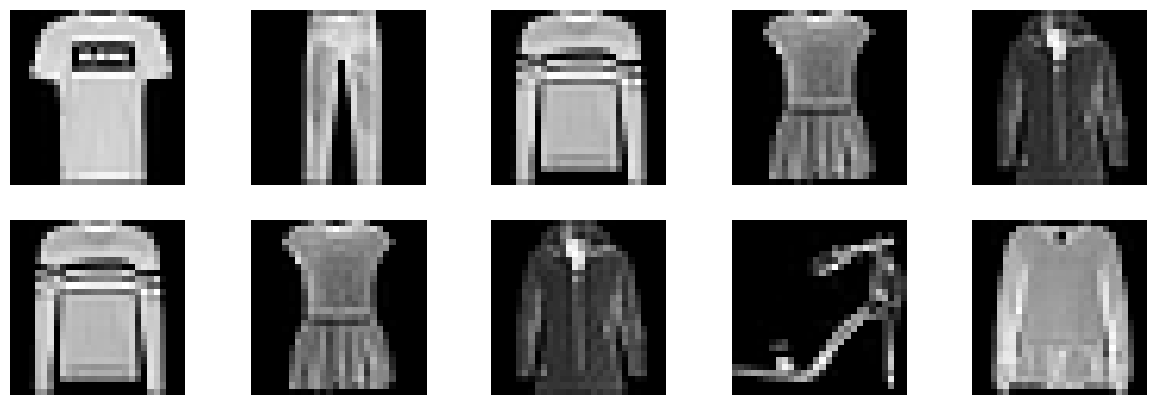

In [15]:
# Vizualizarea atributelor extrase
im_reduced = np.array(list(map(lambda x: pca.inverse_transform(x), X_t20)))
reshaped = np.array(list(map(lambda x: x.reshape(1, -1), im_reduced)))

images =[]
orig_images = []
indexx = []
for label in range(0, len(labels)):
    index = list(y_train).index(label)
    indexx.append(index)
    images.append(reshaped[index])
    orig_images.append(X_train[index])

plot_mnist_grid(images, 2, 5, figsize=(15, 5))
plot_mnist_grid(orig_images, 2, 5, figsize=(15, 5))
print(labels)

### Extragerea Atributelor - 2

In [ ]:
# Procesare si vizualizare a algoritmului hog
def resize_image(img):
    resized_img = resize(img, (128, 64))
    return resized_img

# Aplicare hog
def apply_hog(resized_img):
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    return fd, hog_image

# Procesare si vizualizare a algoritmului hog
X_trainHOG = []
images = []
i = 0
for image in X_train:
    resized_img = resize_image(image)
    fd, hog_image = apply_hog(resized_img)
    X_trainHOG.append(fd)
    images.append(resize(hog_image, (28, 28)))
    i += 1

X_trainHOG = np.array(X_trainHOG)
print("Finished processing training set")

# Aplicam HOG pe setul de testare
X_testHOG = []
i = 0
for image in X_test:
    resized_img = resize_image(image)
    fd, hog_image = apply_hog(resized_img)
    X_testHOG.append(fd)
    i += 1

print("Finished processing test set")

# X_resized = np.array(list(map(lambda x: resize(x, (128,64)), X_train)))
# tuple_list = list(map(apply_hog, X_resized))
# print(X_resized.shape)

# X_trainHOG = np.array([i[0] for i in tuple_list])
# X_hog_image = np.array([i[1] for i in tuple_list])

# # Aplicare HOG pe setul de testare
# X_resized = np.array(list(map(resize_image, X_testt)))
# tuple_list = list(map(apply_hog, X_resized))
# X_testHOG = np.array([i[0] for i in tuple_list])

# Vizualizare pe cele mai numeroase clase
# for fruit in top_classes:
#     index = list(y_train2).index(fruit)
#     showHOG(X_t, X_resized, X_hog_image, index)

Finished processing training set
HOG image 0 done
HOG image 1 done
HOG image 2 done
HOG image 3 done
HOG image 4 done
HOG image 5 done
HOG image 6 done
HOG image 7 done
HOG image 8 done
HOG image 9 done
HOG image 10 done
HOG image 11 done
HOG image 12 done
HOG image 13 done
HOG image 14 done
HOG image 15 done
HOG image 16 done
HOG image 17 done
HOG image 18 done
HOG image 19 done
HOG image 20 done
HOG image 21 done
HOG image 22 done
HOG image 23 done
HOG image 24 done
HOG image 25 done
HOG image 26 done
HOG image 27 done
HOG image 28 done
HOG image 29 done
HOG image 30 done
HOG image 31 done
HOG image 32 done
HOG image 33 done
HOG image 34 done
HOG image 35 done
HOG image 36 done
HOG image 37 done
HOG image 38 done
HOG image 39 done
HOG image 40 done
HOG image 41 done
HOG image 42 done
HOG image 43 done
HOG image 44 done
HOG image 45 done
HOG image 46 done
HOG image 47 done
HOG image 48 done
HOG image 49 done
HOG image 50 done
HOG image 51 done
HOG image 52 done
HOG image 53 done
HOG i

### Selectia Atributelor

In [ ]:
sel = VarianceThreshold(threshold=(0.01))
sel_percentile = SelectPercentile(chi2, percentile=80)
sel_percentile2 = SelectPercentile(percentile=80)

# print(f'PCA: X shape before applying variance threashold: {X_t20.shape}')
# X_t20_scaled = sel.fit_transform(X_t20)
# print(f'PCA: X shape after applying variance threashold: {X_t20_scaled.shape}')

# X_t20_scaled = sel_percentile2.fit_transform(X_t20, y_train)
# X_test20_scaled = sel_percentile2.fit_transform(X_test20, y_test)
# print(f'PCA: X shape after applying percentile selector: {X_t20_scaled.shape}')

print(f'\nHOG: X shape before applying variance threashold: {X_trainHOG.shape}')
X_trainHOG_scaled = sel.fit_transform(X_trainHOG)
X_testHOG_scaled = sel.transform(X_testHOG)
print(f'HOG: X shape after applying variance selector: {X_trainHOG_scaled1.shape}')

PCA: X shape before applying variance threashold: (60000, 20)
PCA: X shape after applying variance threashold: (60000, 20)
PCA: X shape after applying percentile selector: (60000, 16)

HOG: X shape before applying variance threashold: (60000, 3780)


: 

### Antrenarea Modelelor

#### Logistic Regresion

#### SMV

#### Random Forest

#### Gradient Boosted Trees